**Import Packages and files**

In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    
from glob import glob
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

%matplotlib inline

**Unzip Files and Load Data**

In [2]:
from google.colab import drive
import os
import shutil 
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Tumor_Detection/DataSet.zip" -d "/content/drive/My Drive/Tumor_Detection/Data/"

WORKING_DIR = '/content/drive/My Drive/Tumor_Detection/Data/'
TRAIN_DIR = '/content/drive/My Drive/Tumor_Detection/Data/train'
VAL_DIR = '/content/drive/My Drive/Tumor_Detection/Data/val'

Mounted at /content/drive
Archive:  /content/drive/My Drive/Tumor_Detection/DataSet.zip
   creating: /content/drive/My Drive/Tumor_Detection/Data/no/
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no0.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no10.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no100.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1000.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1001.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1002.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1003.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1004.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1005.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1006.jpg  
  inflating: /content/drive/My Drive/Tumor_De

In [3]:
shutil.move(os.path.join(WORKING_DIR,'yes'), os.path.join(TRAIN_DIR, 'yes'))
shutil.move(os.path.join(WORKING_DIR,'no'), os.path.join(TRAIN_DIR, 'no'))

'/content/drive/My Drive/Tumor_Detection/Data/train/no'

**Split Datasett**

In [4]:
from glob import glob
from sklearn.model_selection import train_test_split

yes = glob(TRAIN_DIR + '/yes/*.jpg')
no = glob(TRAIN_DIR + '/no/*.jpg')

yes_train, yes_val = train_test_split(yes, test_size=0.25)
no_train, no_val = train_test_split(no, test_size=0.25)

os.makedirs(os.path.join(VAL_DIR,'yes'))
for file in yes_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'no'))
for file in no_val:
  os.rename(file, file.replace('train','val'))

**Data Augmentation**

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

WIDTH = 240
HEIGHT = 240
BATCH_SIZE = 11

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


**Data Preprocessing**

In [6]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    return new_image

**Model Implementation and Training**

In [7]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [8]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

CLASSES = 2
x = base_model.output                          
x = GlobalAveragePooling2D(name='avg_pool')(x) 
x = Dropout(0.4)(x)                            

predictions = Dense(CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
5/5 [==============================] - 2s 379ms/step - loss: 0.5344 - accuracy: 0.8000 - val_loss: 0.6858 - val_accuracy: 0.8182
Epoch 2/30
5/5 [==============================] - 2s 364ms/step - loss: 0.3634 - accuracy: 0.8182 - val_loss: 0.1790 - val_accuracy: 0.9091
Epoch 3/30
5/5 [==============================] - 2s 378ms/step - loss: 0.2713 - accuracy: 0.9091 - val_loss: 0.4320 - val_accuracy: 0.9091
Epoch 4/30
5/5 [==============================] - 2s 348ms/step - loss: 0.5584 - accuracy: 0.7091 - val_loss: 0.1870 - val_accuracy: 0.9091
Epoch 5/30
5/5 [==============================] - 2s 333ms/step - loss: 0.4501 - accuracy: 0.7818 - val_loss: 0.2011 - val_accuracy: 0.8182
Epoch 6/30
5/5 [==============================] - 2s 328ms/step - loss: 0.5111 - accuracy: 0.8000 - val_loss: 0.0853 - val_accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 306ms/step - loss: 0.5186 - accuracy: 0.7400 - val_loss: 0.1116 - val_accuracy: 1.0000
Epoch 8/30
5/5 [====

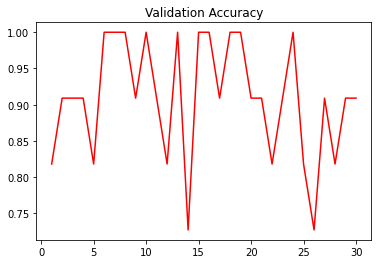

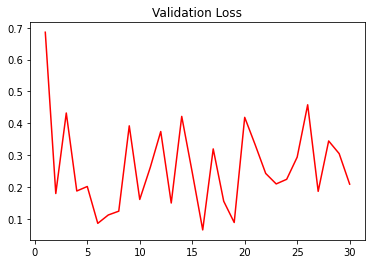

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.title("Validation Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.title("Validation Loss")
plt.show()

In [26]:
z = 0
for w in val_acc:
  z = z + w
print("Average Validation Accuracy: ", z/30)
  

Average Validation Accuracy:  0.9090909202893575


In [27]:
drive.flush_and_unmount()